<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/EmergentRegulator006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

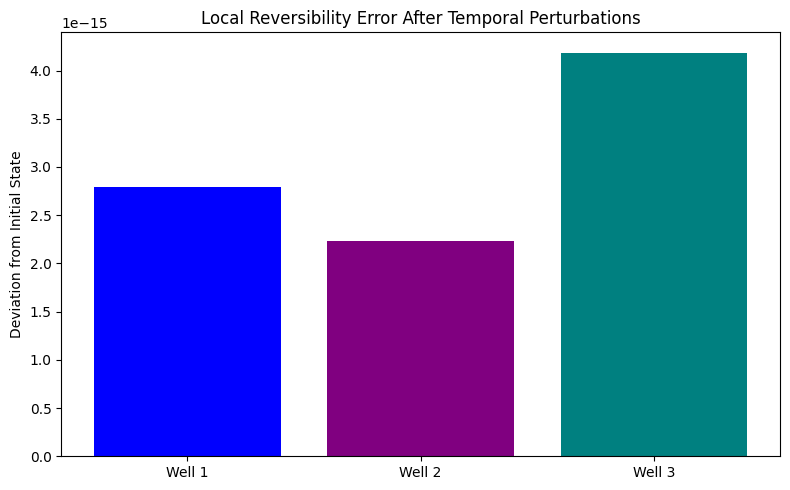

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
T = 50
epochs = 3
x = np.linspace(0, 1, N)
v0 = np.sin(2 * np.pi * x)

# Multi-well curvature field
def multi_well_field(wells):
    field = np.zeros_like(x)
    for center, strength, width in wells:
        field += strength * np.exp(-((x - center)**2) / width)
    return field

# Epoch evolution with staggered perturbations
def evolve_epochs(v_init, curvature, epochs, steps, perturb_schedule):
    v = v_init.copy()
    full_traj = [v.copy()]
    all_noises = []
    for e in range(epochs):
        noises = []
        for t in range(steps):
            noise = np.random.randn(N) * (1.0 / (1.0 + curvature))
            if (e, t) in perturb_schedule:
                start, end, strength = perturb_schedule[(e, t)]
                noise[start:end] += np.random.randn(end - start) * strength
            v += noise
            full_traj.append(v.copy())
            noises.append(noise)
        all_noises.extend(noises)
    return np.array(full_traj), all_noises

# Reverse evolution
def evolve_reverse(v_final, curvature, noises):
    traj = [v_final.copy()]
    v = v_final.copy()
    for noise in reversed(noises):
        v -= noise
        traj.append(v.copy())
    return np.array(traj)

# Local deviation metric
def local_deviation(v_recovered, v_original, region):
    start, end = region
    return np.linalg.norm(v_recovered[start:end] - v_original[start:end])

# Define curvature wells
wells = [
    (0.25, 3.0, 0.01),
    (0.5, 5.0, 0.005),
    (0.75, 2.0, 0.02)
]
C = multi_well_field(wells)

# Define regions
regions = [
    (int(0.20 * N), int(0.30 * N)),  # Well 1
    (int(0.45 * N), int(0.55 * N)),  # Well 2
    (int(0.70 * N), int(0.80 * N))   # Well 3
]
labels = ["Well 1", "Well 2", "Well 3"]
colors = ["blue", "purple", "teal"]

# Perturbation schedule: epoch, time → (start, end, strength)
perturb_schedule = {
    (1, T // 2): (int(0.35 * N), int(0.40 * N), 5.0),
    (2, T // 3): (int(0.60 * N), int(0.65 * N), 4.0)
}

# Run forward across epochs
traj_forward, all_noises = evolve_epochs(v0, C, epochs, T, perturb_schedule)

# Reverse evolution
traj_reverse = evolve_reverse(traj_forward[-1], C, all_noises)

# Compute local deviations
deviations = [
    local_deviation(traj_reverse[-1], v0, region)
    for region in regions
]

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(labels, deviations, color=colors)
plt.title("Local Reversibility Error After Temporal Perturbations")
plt.ylabel("Deviation from Initial State")
plt.tight_layout()
plt.show()
